# Data Generation

We need to generate synthetic data to train a model on. We already have a script which can turn geophone shot data into a CTRM 3D film, so we need to generate synthetic geophone shot data. We will try 2 python libraries to achieve this goal: pygimli, and devito.

# PyGimli

In [ ]:
import numpy as np
# import pandas as pd
import pygimli as pg

pyvista = pg.optImport("pyvista")

In [ ]:
s0 = -50
sf = 50
z0 =  0
zf = -50
# the_world = pg.meshtools.createWorld([s0, s0, z0], [sf, sf, zf], worldMarker=False)
the_cube = pg.meshtools.createCube(size=[(sf-s0), (sf-s0), (zf-z0)], 
                                   pos=[0, 0, 0.5*(zf-z0)])
# the_rect = pg.meshtools.createRectangle([s0, s0, z0], [sf, sf, zf])

In [ ]:
sensors = []
ds = 0.5
for x in np.arange(s0, sf+ds, ds):
    for y in np.arange(s0, sf+ds, ds):
        sensors.append(np.array([x, y, z0]))
for pos in sensors:
    the_cube.createNode(pos)

In [ ]:
pg.show(the_cube)

In [ ]:
import pygimli.meshtools as mt
from pygimli.physics import traveltime
from pygimli.viewer.pv import drawSensors
from pygimli.physics.seismics import solvePressureWave

In [ ]:
mesh = mt.createMesh(the_cube)
mesh.createSecondaryNodes(1)

In [ ]:
scheme = pg.physics.traveltime.createRAData(sensors)

In [ ]:
help(traveltime.createRAData())

# Devito

In [ ]:
from devito import *

In [ ]:
# Import auxiliary modules
import numpy as np

%matplotlib inline

In [ ]:
#NBVAL_IGNORE_OUTPUT
# import sys
# sys.path.insert(0, '../../devito')
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

In [ ]:
# NBVAL_IGNORE_OUTPUT
try:
    # Import gempy
    import gempy as gp
except ModuleNotFoundError:
    # Need to install these
    ! pip install pyvista==0.29
    ! pip install pyqt5
    # Install gempy
    ! pip install gempy==2.2.9
    # Import gempy
    import gempy as gp
    
try:
    # Import jinja2 (used for colour coding geology)
    import jinja2
except ModuleNotFoundError:
    # Install jinja2
    ! pip install jinja2
    # Import jinja2
    import jinja2

In [ ]:
geo_model = gp.create_model('the_world')
geo_model = gp.init_data(geo_model, 
                         extent=(-50., 50.,
                                 -50., 50.,
                                  0., -50.), 
                         resolution=(101, 101, 51))

In [ ]:
gp.set_interpolator(geo_model, output=['geology'], theano_optimizer='fast_compile')

In [ ]:
geo_model.rename_series({'Default series': 'Lower'})

In [ ]:
geo_model.add_surfaces(['earth', 'base'])

In [ ]:
def create_surface(model, points, surface):
    """Add a list of points to a surface in a model"""
    xyz = ('X', 'Y', 'Z')
    for point in points:
        kwargs = {**dict(zip(xyz, point)), 'surface': surface}
        model.add_surface_points(**kwargs)

# The points defining the base of the layer
# earth_points = [(322, 135, -783), 
#                 (635, 702, -791), 
#                 (221, 668, -772), 
#                 (732, 235, -801), 
#                 (442, 454, -702)]

earth_points = [(50, 50, -50), 
                (-50, -50, -50), 
                (-50, 50, -50), 
                (50, -50, -50), 
                (0, 0, -50)]

earth_points = [(50, 50, -50)]

# Call our function
create_surface(geo_model, earth_points, 'earth')

In [ ]:
# Add the surface orientation
geo_model.add_orientations(X=0., Y=0., Z=-50.,
                           surface='earth', pole_vector=(0., 0., 0.))

In [ ]:
sol = gp.compute_model(geo_model)

In [ ]:
sol.values_matrix

# basic test

In [8]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

SEED=42
np.random.seed(SEED)

In [9]:
t0 = 0
tf = 5000
geophs = []
s0 = -50
sf = 50
ds = 0.5
v = 300

defining the geophone locations:

In [10]:
for x in np.arange(s0, sf+(0.5*ds), ds):
    for y in np.arange(s0, sf+(0.5*ds), ds):
        geophs.append(np.array([x, y, 0]))
geophs = np.array(geophs)
geophs.shape
n_geophs = geophs.shape[0]

defining the signal

In [11]:
s_x = 0
s_y = 0
s_z = -20
t = np.arange(t0, tf)
sig = lambda t: np.sinc(0.2*(t - 200))

In [12]:
dists = np.sqrt(((np.array([[s_x, s_y, s_z]] * n_geophs) - geophs)**2).sum(axis=1))
dists.shape, dists.min()

((40401,), 20.0)

In [13]:
dt = dists / v
dt.shape

(40401,)

In [14]:
cos_phi = np.abs(s_z) / dists
cos_phi.shape

(40401,)

In [15]:
amps = cos_phi / (dists**2)
amps.shape

(40401,)

In [16]:
shots = np.zeros((n_geophs, tf-t0))
shots.shape

(40401, 5000)

In [17]:
for t in np.arange(t0, tf):
    shots[:, t] = amps*sig(t-dt)

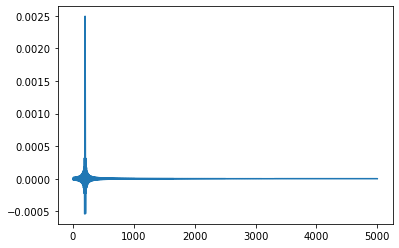

In [18]:
plt.plot(np.arange(t0, tf), shots[20000, :])

## generating a random dataset

we will generate 20 random events, each one will have 1-5 pulses with varying characteristics

In [19]:
def gen_a_shot(f, params, geophs, loc, t_span, v):
    """
    given a geophoes geometry, a disturbance location and type, 
    will generate a a timeline with only this disturbance
    :param f: a function describing the disturbance, of form f(t, *params)
    :param params: a list of params to pass to f() after the time
    :param geophs: a numpy array containing the locations of the geophones
    :param loc: the location of the disturbance
    :param t_span: the amount of time the recorded in the shot
    :param v: the speed of sound in the medium
    :return: a numpy array containing the shot data of the disturbance
    """
    # save the number of geophones in memory
    n_geophs = geophs.shape[0]
    # find the distance of each geophone from the source
    dists = np.sqrt(((np.array([[loc[0], loc[1], loc[2]]] * n_geophs) - geophs)**2).sum(axis=1))
    # find the time the disturbance takes to travel to each geophone
    dt = dists / v
    # calculate the decay of the amplitude by the time it arrives to each geophone
    cos_phi = np.abs(s_z) / dists
    amps = cos_phi / (dists**2)
    # create an object to hold the output data
    shots = np.zeros((n_geophs, t_span[1] - t_span[0]))
    for t in np.arange(t_span[0], t_span[1]):
        shots[:, t] = amps*f(t-dt, * params)
    return shots

In [47]:
def gen_shots(f, param_range, geophs, loc_range, N, max_subs, break_range, sub_range, v, seed=42):
    """
    generate a sequence of disturbances and record shot data
    :param f: a function describing the disturbance, of form f(t, t0, *params)    
    :param param_range: 2 lists describing the range of params that can be passed to to f() 
    after the time variabel: [params_0, params_f]
    :param geophs: a numpy array containing the locations of the geophones
    :param loc_range: 2 lists descrbing the bounds of the bpossible disturbances:
    [(x_0, y_0, z_0), (x_f, y_f, z_f)]
    :param N: the number of disturbances
    :param max_subs: how many disturbances at most can make each disturbance
    :param break_range: a range of time to wait between disturbances
    :param sub_range: a range of time to wait between sub disturbances
    :param v: the speed of sound in the medium
    :param seed: used to set the randomness of the model
    :return: a numpy array containing the shot data of the disturbance
    """
#     raise NotImplementedError
    # calculate the moment each disturbance takes place, and total sim time
    T = 0    
    dis_times = []
    dis_dt = []
    for _ in range(N):
        T += np.random.randint(*break_range)
        n_subs = np.random.randint(1, max_subs+1)
        t_wait = np.random.randint(*sub_range)
        dis_dt.append(t_wait)
        sub_dists = []
        for _ in range(n_subs):
            T += t_wait
            sub_dists.append(T)
        dis_times.append(sub_dists)
    T += np.random.randint(*break_range)
    
    # create object to hold output data
    outp = np.zeros((n_geophs, T))
    y_res = np.zeros((4, T))
    
    # create a random disturbance each dis moment
    for disturb_range, dis_wait in tqdm(zip(dis_times, dis_dt)):
        params = []
        for a, b in zip(param_range[0], param_range[1]):
            params.append(a + ((b-a) * np.random.random()))
        loc = []
        for a, b in zip(loc_range[0], loc_range[1]):
            loc.append(a + ((b-a) * np.random.random()))
        
        # TODO: calculate tt0 and ttf
        tt0 = disturb_range[0]
        ttf = disturb_range[-1] + dis_wait
        y_res[:, tt0:ttf] = np.array([[1] + loc] * (ttf - tt0)).T
            
        for disturb_t in disturb_range:
            ff = lambda t: f(t, disturb_t, *params)
            outp += gen_a_shot(ff, [], geophs, loc, [0, T], v)
        
    return outp, y_res

In [48]:
np.array([[1,2,3,4]]*8).shape

(8, 4)

In [49]:
sig = lambda t, t0, A, w: A * np.sinc(w*(t - t0))

In [50]:
data, y_true = gen_shots(sig, 
                          [[0.9, 0.1], [1.1, 0.3]], 
                          geophs, 
                          [(s0, s0, 0), (sf, sf, -50)], 
                          N=5, 
                          max_subs=5, 
                          break_range=[400, 500], 
                          sub_range=[50, 100], 
                          v=300, 
                          seed=42)

5it [00:40,  8.11s/it]


In [51]:
data.shape, y_true.shape

((40401, 3803), (4, 3803))

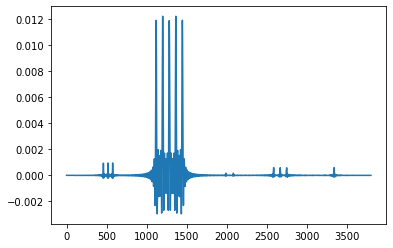

In [52]:
plt.plot(np.arange(0, data.shape[1]), data[20000, :])

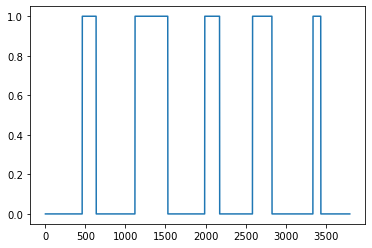

In [53]:
plt.plot(np.arange(0, data.shape[1]), y_true[0, :])